# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# Useful

In [3]:
def check_shape_head(df : pd.DataFrame):
    assert isinstance(df, pd.DataFrame), f"{df} sould be a pandas dataframe"
    print(df.shape)
    return df.head(2)

# Retrieve data

In [4]:
# take environment variables from .env.
# load_dotenv()

data_path = os.getenv("DATA_HR")

#Retrieve dataset from local directory
dataset = pd.read_csv(data_path)

pd.set_option('display.max_columns', None)
check_shape_head(dataset)

(14999, 62)


ID    Name  Department GEO             Role  Rising_Star  Will_Relocate  \
0   1  BRADDY  Operations  US               VP          NaN              0   
1   2   BORST       Sales  UK  Senior Director          NaN              0   

   Critical  Trending Perf  Talent_Level  Validated_Talent_Level  \
0       1.0              3             6                       6   
1       NaN              3             6                       6   

   Percent_Remote  EMP_Sat_OnPrem_1  EMP_Sat_OnPrem_2  EMP_Sat_OnPrem_3  \
0             0.4               3.0               3.0               4.0   
1             0.4               3.0               3.0               4.0   

   EMP_Sat_OnPrem_4  EMP_Sat_OnPrem_5  EMP_Sat_Remote_1  EMP_Sat_Remote_2  \
0               3.0               5.0                 2                 3   
1               3.0               5.0                 2                 3   

   EMP_Sat_Remote_3  EMP_Sat_Remote_4  EMP_Sat_Remote_5  EMP_Engagement_1  \
0                 2                 3                 2                 5   
1                 2                 3                 2                 5   

   EMP_Engagement_2  EMP_Engagement_3  EMP_Engagement_4  EMP_Engagement_5  \
0                 5                 4                 4                 3   
1                 5                 4                 4                 3   

   last_evaluation  number_project  average_montly_hours  time_spend_company  \
0             0.36               3                   168                   3   
1             0.36               5                   159                   2   

   Work_accident  left_Company  CSR Factor  promotion_last_5years       sales  \
0              1             0         NaN                      0       sales   
1              0             0         NaN                      0  accounting   

  salary Gender  LinkedIn_Hits  Emp_Work_Status2  Emp_Work_Status_3  \
0    low      M              5                 4                  3   
1    low      F             58                 3                  3   

   Emp_Work_Status_4  Emp_Work_Status_5  Emp_Identity  Emp_Role  Emp_Position  \
0                  1                  1             1         1             2   
1                  4                  3             2         1             2   

   Emp_Title  Women_Leave  Men_Leave  Emp_Competitive_1  Emp_Competitive_2  \
0          1          NaN        1.0                  2                  4   
1          1          0.0        NaN                  2                  2   

   Emp_Competitive_3  Emp_Competitive_4  Emp_Competitive_5  \
0                  2                  2                  2   
1                  1                  4                  1   

   Emp_Collaborative_1  Emp_Collaborative_2  Emp_Collaborative_3  \
0                    2                    2                    2   
1                    3                    2                    5   

   Emp_Collaborative_4  Emp_Collaborative_5  Sensor_StepCount  \
0                    1                    5              1841   
1                    1                    5              1990   

   Sensor_Heartbeat(Average/Min)  Sensor_Proximity(1-highest/10-lowest)  
0                             61                                      9  
1                             90                                      8

# Data preparation

In [5]:
# Remove unwanted columns
dropped_columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales']

dataset.drop(columns = dropped_columns, inplace = True)

In [6]:
# Rename columns
dataset = dataset.rename(columns={
                                    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
                                    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
                                })
# check_shape_head(dataset)

In [7]:
# Convert column names to lower snake case
dataset.columns = dataset.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')
# check_shape_head(dataset)

# Essais

In [8]:
dataset_essais = dataset.copy()

In [9]:
# # impute binary missing values for critical column
# # covert gender column into binary classification column

# def imputer_critical(x):
#     x = x.apply(lambda y: y.map({1 : 1, np.nan: 0}))
#     return x

# def imputer_gender(x):
#     x = x.apply(lambda y: y.map({'F': 1, 'M': 0}))
#     return x

# basic_column_transformer = make_column_transformer(
#     (FunctionTransformer(imputer_gender,feature_names_out ='one-to-one'), ['gender']),
#     (FunctionTransformer(imputer_critical,feature_names_out ='one-to-one'), ['critical'])
# )
                                                    
# basic_column_transformer

In [10]:
# result = basic_column_transformer.fit_transform(dataset_essais)
# basic_column_transformer.get_feature_names_out()

# pd.DataFrame(result, columns=basic_column_transformer.get_feature_names_out())

# General prerequisities

In [11]:
# checking missing values
dataset.isnull().sum().sort_values(ascending=False);

# impute binary missing values for critical column
dataset.loc[dataset['critical'].isna(), 'critical'] = 0

# covert gender column into binary classification column
dataset['gender'] = dataset['gender'].map({'F': 1, 'M': 0})

# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']
imputer = SimpleImputer(strategy='most_frequent')
dataset[columns_to_impute] = imputer.fit_transform(dataset[columns_to_impute])

# target imbalancing
# the target is imbalanced, however we aim to predict those consumers who will be retained within the company,
# and this is 76% of the data, so we rebalancing is necessary.

dataset['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

In [12]:
dataset['emp_sat_onprem_5']

0        5.0
1        5.0
2        5.0
3        5.0
4        5.0
        ... 
14994    4.0
14995    4.0
14996    4.0
14997    4.0
14998    4.0
Name: emp_sat_onprem_5, Length: 14999, dtype: float64

# Numerical Features Data Cleaning ONLY

/tmp/ipykernel_102700/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_102700/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_102700/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_102700/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and se

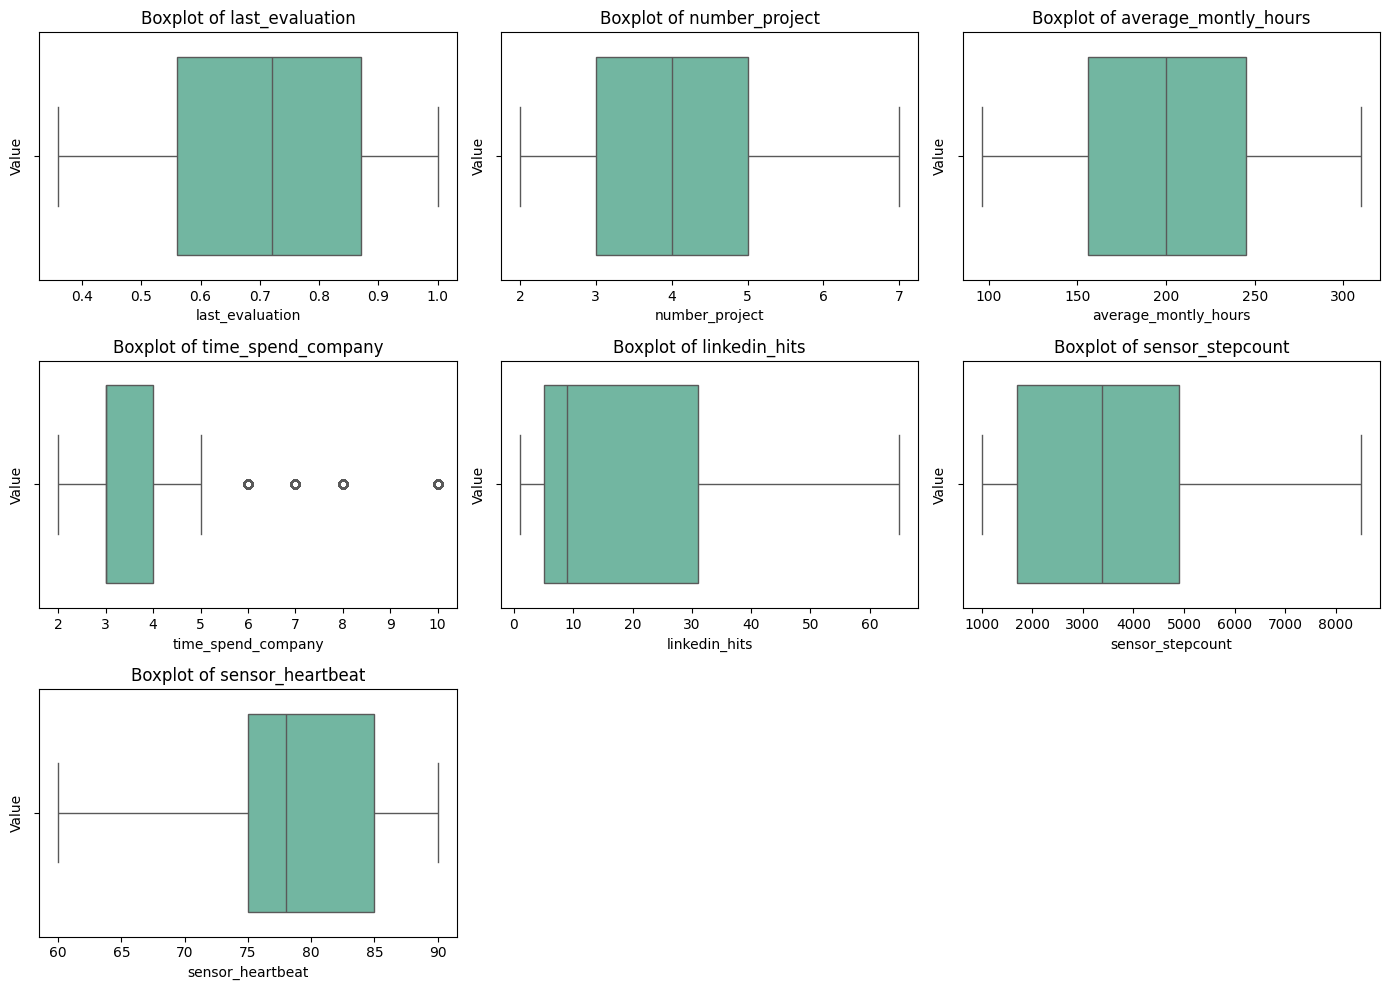

In [13]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dataset[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [14]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.
rb_scaler = RobustScaler()
dataset['time_spend_company'] = rb_scaler.fit_transform(dataset[['time_spend_company']])

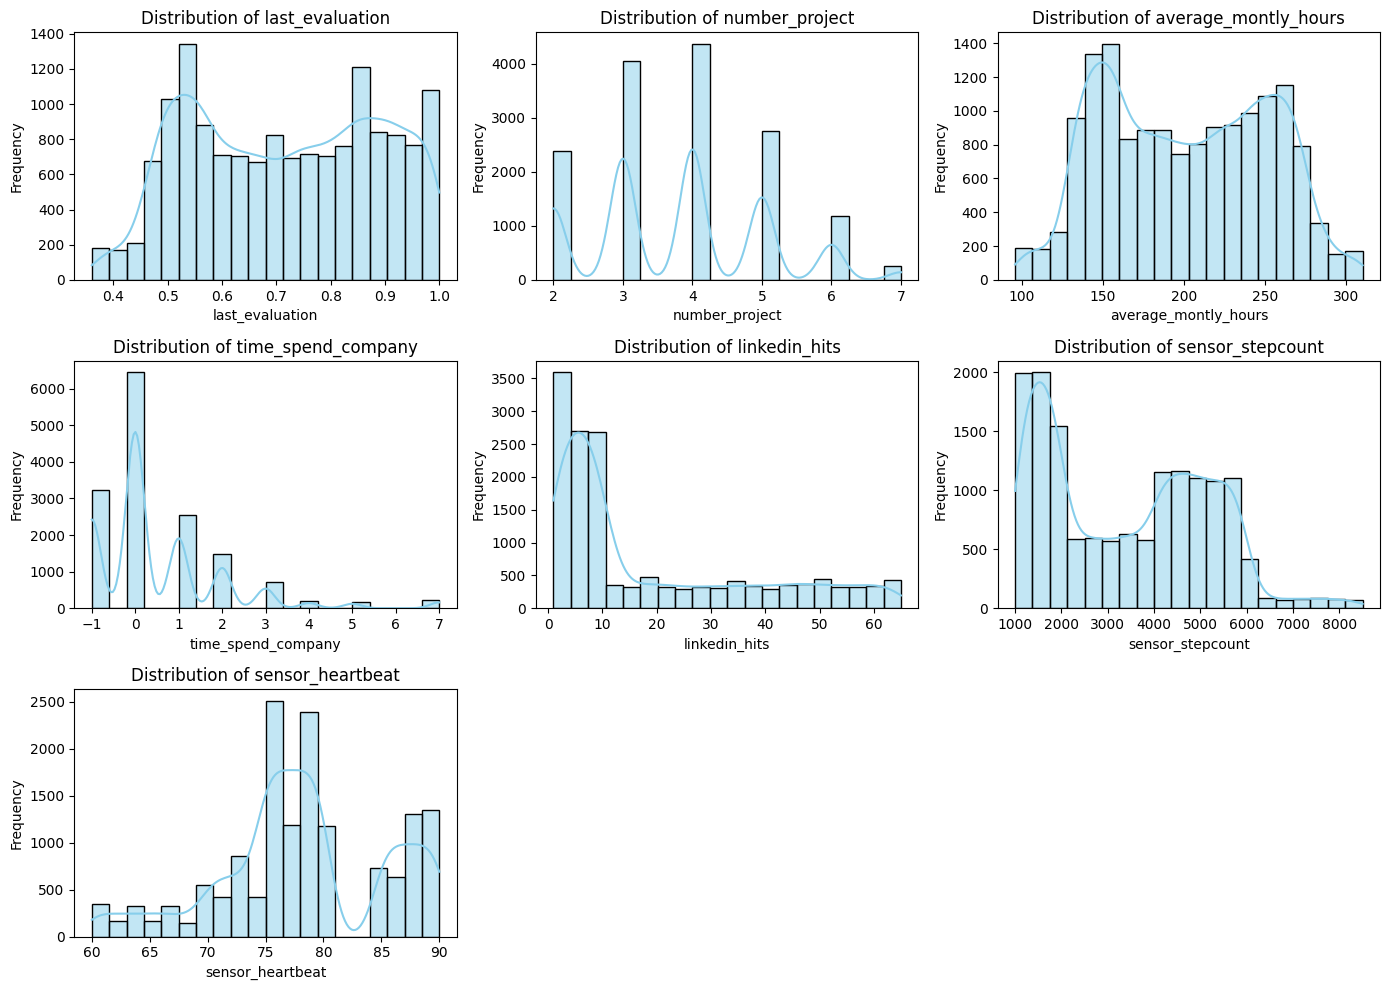

In [15]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# for all other numerical variables, use the minmaxscaler
minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
dataset[minmaxscaler_columns] = scaler.fit_transform(dataset[minmaxscaler_columns])

# Categorical Features ONLY Feature Engineering

In [17]:
# ordinal encoding for salary
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(dataset[['salary']])
print(ordinal_encoder.categories_)
dataset['encoded_salary'] = ordinal_encoder.transform(dataset[['salary']]) # 1 = low, 2 = medium, 3 = high
dataset.drop(columns = ['salary'], inplace = True)

[array(['high', 'low', 'medium'], dtype=object)]


In [18]:
# OneHotEncoding for department, geo and role
ohe_columns = ['department', 'geo', 'role']
ohe = OneHotEncoder(sparse_output = False)
ohe_data = ohe.fit_transform(dataset[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))
encoded_dataset = pd.concat([dataset, ohe_df], axis=1)
encoded_dataset.drop(columns = ['department', 'geo', 'role'], inplace = True)

In [19]:
check_shape_head(encoded_dataset)

(14999, 63)


will_relocate  critical  percent_remote  emp_sat_onprem_4  \
0              0       1.0             0.4               3.0   
1              0       0.0             0.4               3.0   

   emp_sat_onprem_5  emp_sat_remote_1  emp_sat_remote_2  emp_engagement_1  \
0               5.0                 2                 3                 5   
1               5.0                 2                 3                 5   

   last_evaluation  number_project  average_montly_hours  time_spend_company  \
0              0.0             0.2              0.336449                 0.0   
1              0.0             0.6              0.294393                -1.0   

   work_accident  left_company  promotion_last_5years  gender  linkedin_hits  \
0              1             0                      0       0       0.062500   
1              0             0                      0       1       0.890625   

   emp_work_status2  emp_work_status_3  emp_work_status_4  emp_work_status_5  \
0                 4                  3                  1                  1   
1                 3                  3                  4                  3   

   emp_identity  emp_role  emp_position  emp_title  women_leave  men_leave  \
0             1         1             2          1          NaN        1.0   
1             2         1             2          1          0.0        NaN   

   emp_competitive_1  emp_competitive_2  emp_competitive_3  emp_competitive_4  \
0                  2                  4                  2                  2   
1                  2                  2                  1                  4   

   emp_competitive_5  emp_collaborative_1  emp_collaborative_2  \
0                  2                    2                    2   
1                  1                    3                    2   

   emp_collaborative_3  emp_collaborative_4  emp_collaborative_5  \
0                    2                    1                    5   
1                    5                    1                    5   

   sensor_stepcount  sensor_heartbeat  sensor_proximity  encoded_salary  \
0          0.112133          0.033333                 9             1.0   
1          0.132000          1.000000                 8             1.0   

   department_Finance  department_Human Resources  department_IT  \
0                 0.0                         0.0            0.0   
1                 0.0                         0.0            0.0   

   department_Operations  department_Sales  department_Warehouse  \
0                    1.0               0.0                   0.0   
1                    0.0               1.0                   0.0   

   geo_Australia  geo_China  geo_Colombia  geo_France  geo_Japan  geo_Korea  \
0            0.0        0.0           0.0         0.0        0.0        0.0   
1            0.0        0.0           0.0         0.0        0.0        0.0   

   geo_Turkey  geo_UK  geo_US  role_Director  role_Level 1  role_Level 2-4  \
0         0.0     0.0     1.0            0.0           0.0             0.0   
1         0.0     1.0     0.0            0.0           0.0             0.0   

   role_Manager  role_Senior Director  role_Senior Manager  role_VP  
0           0.0                   0.0                  0.0      1.0  
1           0.0                   1.0                  0.0      0.0

# Assumption : drop Women_Leave and Men_Leave columns

In [20]:
# Need to decide together.
encoded_dataset.drop(columns = ['women_leave', 'men_leave'], inplace = True)

In [21]:
# Updating dropped columns
for col in ['women_leave', 'men_leave']:
    dropped_columns.append(col)
    
dropped_columns;

# Feature correlation

<Axes: >

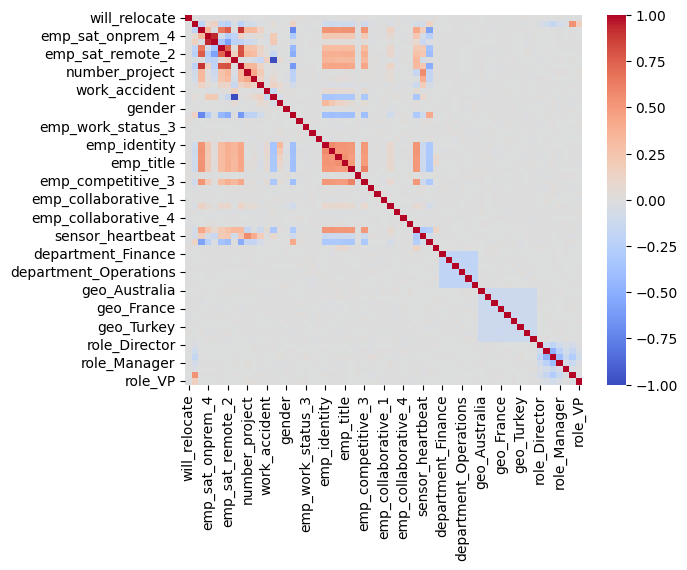

In [22]:
#Compute feature correlation
sns.heatmap(encoded_dataset.corr(), cmap='coolwarm')

In [23]:
# Calculate the correlation matrix
corr_matrix = encoded_dataset.corr()

In [24]:
# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

In [25]:
# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

# Select highly correlated features >= 0.7 or <= -0.7
correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]
correlated_features

feature_1         feature_2  correlation
177  emp_sat_onprem_5  emp_sat_onprem_4     0.930062
124   last_evaluation    percent_remote     0.897223
346   last_evaluation  emp_sat_remote_2     0.805922
292   last_evaluation  emp_sat_remote_1     0.796292
122  emp_sat_remote_2    percent_remote     0.762327
290  emp_sat_remote_2  emp_sat_remote_1     0.735748
132     linkedin_hits    percent_remote    -0.713644
404      left_company  emp_engagement_1    -1.000000

In [26]:
# remove highly correlated features >= 0.7 or <= -0.7
encoded_dataset.drop(columns=['emp_sat_onprem_4','percent_remote',
                'emp_sat_remote_2','emp_sat_remote_1',
                'emp_engagement_1'], inplace = True)

In [27]:
# Updating dropped columns
for col in ['emp_sat_onprem_4','percent_remote',
                'emp_sat_remote_2','emp_sat_remote_1',
                'emp_engagement_1']:
    dropped_columns.append(col)

# List of dropped columns

In [28]:
dropped_columns

['ID',
 'Name',
 'Rising_Star',
 'Trending Perf',
 'Talent_Level',
 'Validated_Talent_Level',
 'EMP_Sat_OnPrem_1',
 'EMP_Sat_OnPrem_2',
 'EMP_Sat_OnPrem_3',
 'EMP_Sat_Remote_3',
 'EMP_Sat_Remote_4',
 'EMP_Sat_Remote_5',
 'EMP_Engagement_2',
 'EMP_Engagement_3',
 'EMP_Engagement_4',
 'EMP_Engagement_5',
 'CSR Factor',
 'sales',
 'women_leave',
 'men_leave',
 'emp_sat_onprem_4',
 'percent_remote',
 'emp_sat_remote_2',
 'emp_sat_remote_1',
 'emp_engagement_1']

# Pipeline

## Basic transformer

In [29]:
# impute binary missing values for critical column
# covert gender column into binary classification column

def imputer_critical(x):
    x = x.apply(lambda y: y.map({1 : 1, np.nan: 0}))
    return x

def imputer_gender(x):
    x = x.apply(lambda y: y.map({'F': 1, 'M': 0}))
    return x

basic_column_transformer = make_column_transformer(
    (FunctionTransformer(imputer_gender,feature_names_out ='one-to-one'), ['gender']),
    (FunctionTransformer(imputer_critical,feature_names_out ='one-to-one'), ['critical']),
    (SimpleImputer(strategy='most_frequent'), ['emp_sat_onprem_5'])
)
                                                    
basic_column_transformer

ColumnTransformer(transformers=[('functiontransformer-1',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function imputer_gender at 0x7f1c0649ad40>),
                                 ['gender']),
                                ('functiontransformer-2',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function imputer_critical at 0x7f1c0649add0>),
                                 ['critical']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['emp_sat_onprem_5'])])

In [30]:
#Verification
result = basic_column_transformer.fit_transform(dataset_essais)
basic_column_transformer.get_feature_names_out()

pd.DataFrame(result, columns=basic_column_transformer.get_feature_names_out())

functiontransformer-1__gender  functiontransformer-2__critical  \
0                                0.0                              1.0   
1                                1.0                              0.0   
2                                1.0                              0.0   
3                                0.0                              0.0   
4                                1.0                              0.0   
...                              ...                              ...   
14994                            1.0                              0.0   
14995                            1.0                              0.0   
14996                            1.0                              0.0   
14997                            0.0                              0.0   
14998                            1.0                              0.0   

       simpleimputer__emp_sat_onprem_5  
0                                  5.0  
1                                  5.0  
2                                  5.0  
3                                  5.0  
4                                  5.0  
...                                ...  
14994                              4.0  
14995                              4.0  
14996                              4.0  
14997                              4.0  
14998                              4.0  

[14999 rows x 3 columns]

## Numerical 

In [31]:
num_column_transformer = make_column_transformer(
                                                    (MinMaxScaler(), ['last_evaluation','number_project',
                                                                      'average_montly_hours','linkedin_hits',
                                                                      'sensor_stepcount','sensor_heartbeat']),
                                                    (RobustScaler(), ['time_spend_company'])
                                                    )

## Categorical

In [32]:
cat_column_transformer = make_column_transformer(
                                (OneHotEncoder(sparse_output = False), ['department', 'geo', 'role']),
                                (RobustScaler(), ['time_spend_company'])
                                )

In [33]:
['department', 'geo', 'role']

['department', 'geo', 'role']

In [34]:

num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('rounder', rounder)])


preprocessor = make_column_transformer([
    ('num_transformer', num_transformer, ['bmi', 'age']),
    ('cat_transformer', cat_transformer, ['region', 'smoker'])],
    remainder='passthrough')
preprocessor


NameError: name 'Pipeline' is not defined

In [ ]:
print i 

In [ ]:
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
cat_transformer = OneHotEncoder()


preproc_basic = make_column_transformer(
                                        (num_transformer, ['age', 'bmi']),
                                        (cat_transformer, ['smoker', 'region']),
                                        remainder='passthrough'
                                    )


In [ ]:
rounder = FunctionTransformer(lambda array: np.round(array, decimals=2))

In [ ]:
# impute binary missing values for critical column
dataset.loc[dataset['critical'].isna(), 'critical'] = 0

In [ ]:
impute_critical = 

In [ ]:
basic_transformer

In [ ]:
make_pipeline(
                SimpleImputer(), 
                StandardScaler())

In [ ]:
print i

# Define X (features)

In [ ]:
#Features
X = encoded_dataset.drop(columns=['left_company'])
check_shape_head(X)

# Define y (target)

In [ ]:
#Target
y = encoded_dataset['left_company']

# Learning curves

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

# train_sizes = [25,50,75,100,250,500,750,1000,1150]
train_sizes = np.linspace(0.1, 1.0, 5)

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000), X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

# Train test split

In [ ]:
# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=10)

In [ ]:
#Check shapes
print(f"X_train shape is : {X_train.shape}")
print(f"y_train shape is : {y_train.shape}\n")
print(f"X_test shape is : {X_test.shape}")
print(f"y_test shape is : {y_test.shape}")

# Logistic regression

In [ ]:
# Instanciate the logistic regression model
log_reg_mdl = LogisticRegression(max_iter=500, class_weight='balanced')

#Fitting the model to train set (features and target)
log_reg_mdl.fit(X_train, y_train)

In [ ]:
#Evaluation

y_pred = log_reg_mdl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print(classification_report(y_test, y_pred))